In [1]:
import os
os.chdir('/Users/Olivier/anaconda3/envs/FEM')
%load_ext autoreload

In [2]:
%autoreload 2
from FEMOL import RectangleQuadMesh, FEM_Problem, TOPOPT_Problem, PlateBendingResults
from FEMOL_utils import *
from FEMOL_materials import general_carbon
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video, clear_output
np.set_printoptions(linewidth=150)
%matplotlib inline

# Plate model guitar coating top opt

## domain functions

In [3]:
# Domain functions

def outside_circle(x_pos, y_pos, R):
    
    def circle(x, y):
        
        if (x-x_pos)**2 + (y-y_pos)**2 >= R**2:
            return True
        else:
            return False
    
    return circle

def inside_circle(x_pos, y_pos, R):
    
    def circle(x, y):
        
        if (x-x_pos)**2 + (y-y_pos)**2 <= R**2:
            return True
        else:
            return False
    
    return circle

def outside_box(x1, x2, y1, y2):
    """
    x1 < x2 & y1 < y2
    """

    def box(x, y):
        
        return ~((x > x1) & (x < x2) & (y > y1) & (y < y2))
    
    return box

def guitar_sides(Lx, Ly):
    angle = np.pi/6
    p = angle/(np.pi/2)
    x1 = 2*Ly/6 + 2*Ly/6 * np.sin(angle)
    y1 = 2*Ly/6 - 2*Ly/6 * np.cos(angle)
    x2 = Lx - Ly/4 - Ly/4 * np.sin(angle)
    y2 = 2*Ly/6 - Ly/4 * np.cos(angle)
    a, b, c, d = create_polynomial(x1, y1, x2, y2, p)
    
    def sides(x, y):
        Y_val = a*x**3 + b*x**2 + c*x + d
        return ~((x > x1) & (x < x2) & (y > Y_val) & (y < -Y_val+Ly))

    return sides

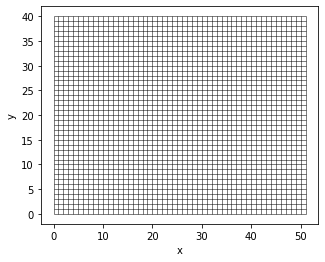

In [15]:
# Mesh

nelx = 51 # elements in the x direction
nely = int(nelx*0.7861635220125787) # elements in the y direction

# Creating the mesh
Lx = nelx
Ly = nely

mesh = RectangleQuadMesh(Lx, Ly, nelx, nely)
mesh.plot()

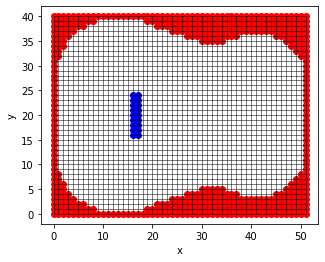

In [16]:
# Initialise the problem
Guitar_FEM = FEM_Problem(mesh)

# Materials
Base = general_flax()
Brace = general_carbon()

# Layups
layup_base = [90,0,45,-45,0,90]
layup_coating = [90,0,90,0]
material = general_flax()

# Heights
base_ho = material.hi*len(layup_base)
coating_ho = material.hi*len(layup_coating)
coating_height = base_ho/2 + coating_ho/2 # Specify the middle plane height

# FEM Problem
Guitar_FEM = FEM_Problem(mesh)

# Element stiffness matrices
Ke_base = Guitar_FEM.complete_plate_Ke(layup=layup_base, material=material, Gs=1000., out=True)
Ke_coating = Guitar_FEM.complete_plate_Ke(layup=layup_coating, material=material, Gs=1000., zc=coating_height, out=True)

# Outside domain
circle1 = outside_circle((2*Ly/6), (2*Ly/6), (2*Ly/6))
circle2 = outside_circle((2*Ly/6), (4*Ly/6), (2*Ly/6))
circle3 = outside_circle((Lx-Ly/4) , 2*Ly/6, Ly/4)
circle4 = outside_circle((Lx-Ly/4) , 4*Ly/6, Ly/4)
box1 = outside_box(0, Lx, 2*Ly/6, 4*Ly/6)
sides = guitar_sides(Lx, Ly)
sound_hole = inside_circle(2*Lx/3, Ly/2, Ly/7)

def fixed_guitar(x, y):
    """
    Fixed boundary conditions surrounding the guitar
    """
    if np.array([circle1(x,y), circle2(x,y), circle3(x,y), circle4(x,y), box1(x,y), sides(x, y)]).all():
        return True
    else:
        return False
    
def voided_guitar(x, y):
    """
    Parts where there is no material on the guitar
    """
    if np.array([circle1(x,y), circle2(x,y), circle3(x,y), circle4(x,y), box1(x,y), sides(x, y)]).all():
        return True
    elif sound_hole(x,y):
        return True
    else:
        return False 

x = [[Lx/3.2, Lx/3]]
y = [[8*Ly/20, 12*Ly/20]]
force_domain = create_domain(x, y)
force = [0, 0, 0, 0, 100, 0]

Guitar_FEM.add_fixed_domain(fixed_guitar, ddls=[0, 1, 2])
Guitar_FEM.add_forces(force, force_domain)
Guitar_FEM.assemble_plate_K()
Guitar_FEM.fix_boundary()
Guitar_FEM.plot()

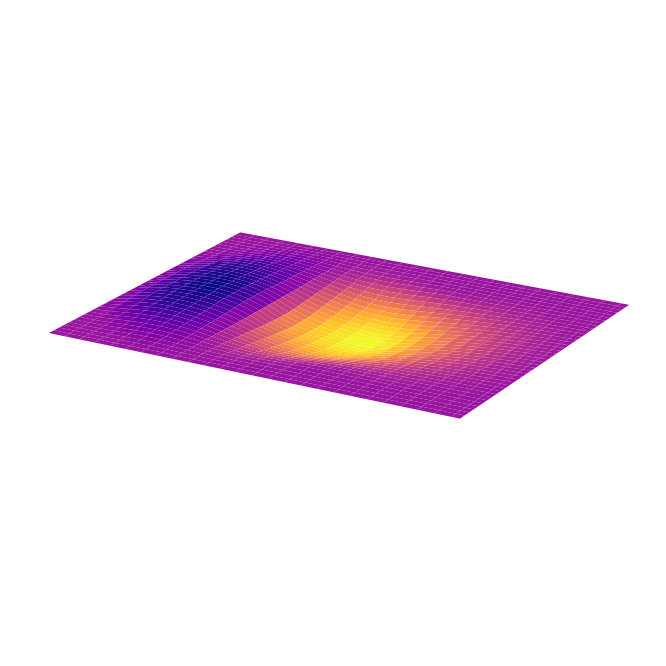

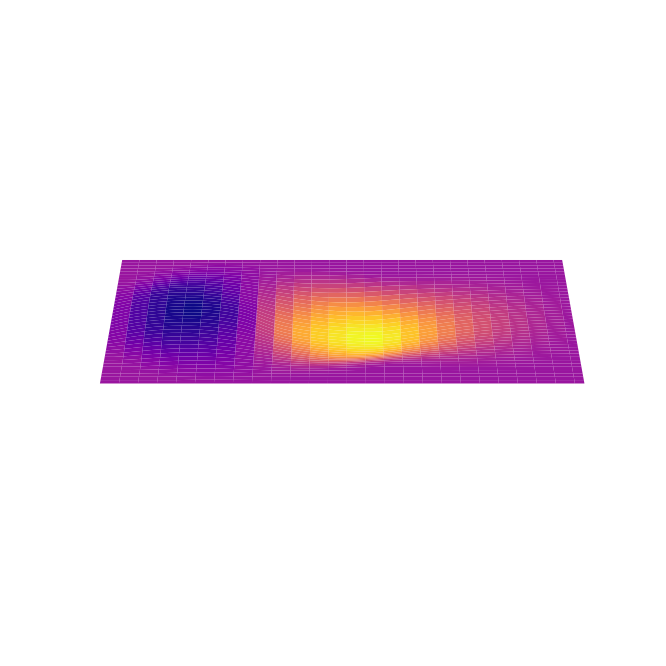

In [29]:
Result = Guitar_FEM.solve()
Result.Z_displacement_3D(scale=0.05, azim=-60, elev=20)
Result.Z_displacement_3D(scale=0.05, azim=-90, elev=20)

## TOPOPT solve

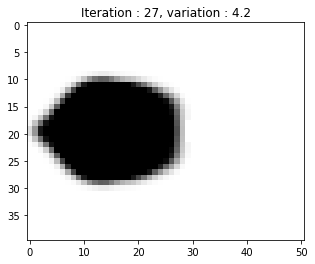

In [28]:
TOPOPT_Guitar = TOPOPT_Problem(Guitar_FEM, volfrac=0.2, problem='coating')
TOPOPT_Guitar.define_void_domain(voided_guitar)
TOPOPT_Guitar.define_coating_ke(Ke_base, Ke_coating)

result = TOPOPT_Guitar.solve(converge=0.05)

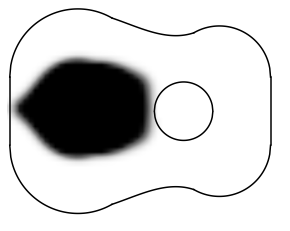

In [30]:
result.plot()
guitar_outline(Lx, Ly)